In [1]:
%pylab inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
set_printoptions(linewidth=300, threshold=200000, suppress=True, precision = 8)


Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(16,9)
def rf1h(dx, N, p):
    e, No = p
    dN = e * No * (N > 0)
    return -dN * dx

def rf1r(dx, N, p):
    e = p[0]
    dN = - e * N
    return dN * dx


def rf2h(dx, N, p):
    a, Ht, No = p
    dN = (a * No) / (1 + a * Ht * No) * (N > 0)
    return -dN * dx

def rf2r(dx, N, p):
    a, Ht, No = p
    dN = (a * N) / (1 + a * Ht * N)
    return -dN * dx


def rf3h(dx, N, p):
    a, Ht, No = p
    N2 = No ** 2
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    return -dN * dx

def rf3r(dx, N, p):
    a, Ht, No = p
    N2 = N ** 2
    dN = (a * N2) / (1 + a * Ht * N2)
    return -dN * dx

def rfgh(dx, N, p):
    a, Ht, k, No = p
    N2 = No ** k
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    return -dN * dx

def rfgr(dx, N, p):
    a, Ht, k, No = p
    N2 = N ** k
    dN = (a * N2) / (1 + a * Ht * N2)
    return -dN * dx


def rfl(dx, sv, p):
    """
    Functional response with learning
    la = learning in a
    lH = learning in handling time
    Mnt = minimum handling time
    ha = host depletion
    No = N initial
    sv = state variables
    """
    N, a, Ht = sv
    la, lH, Mnt, hd, No = p[:5]
    #print(la, lH, N, a, Ht)
    if hd: N2 = N
    else:  N2 = No
    
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    da = la * (1 - a) * dN
    dH = lH * (Ht - Mnt) * dN
    return array([-dN, da, -dH]) * dx


def rk4(f, h, y, p):
    dx = h/2.
    k1 = f(dx, y, p)
    k2 = f(dx, y + k1 / 2, p)
    k3 = f(dx, y + k2 / 2, p)
    k4 = f(dx, y + k3, p)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def plot_funcion(f, p, nombre = '', grafica = "integral", sv = 1, tmax = 1, ax = False):
    import crf_dinamica as rf
    if len(p) == 7:
        fraccion = 1024
    else:
        fraccion = 128
    y = zeros((tmax * fraccion + 1, sv))
    x = linspace(0, tmax, tmax * fraccion + 1)
    
    y[0] = p[-sv:]
    if len(p) == 7:
        y = rf.rfl(array(p, dtype = float64), tmax)
    else:
        for i in range(1, y.shape[0]):
            y[i] = rk4(f, x[1] - x[0], y[i-1], p)
        y[:,0] = y[0,0] - y[:,0]
    if grafica == "integral":
        ax.plot(x, y[:,0], label = nombre)
    elif grafica == "derivada":
        ax.plot(x[1:], (y[1:,0] - y[:-1,0]), label = nombre)
    if grafica == "learning":
        print(y)
    return x, y

def plot_rfn(f, p, nombre = '', grafica = "integral", sv = 1, tmax = 1, Nmax = 100, ax = False):
    
    x = linspace(0.5, Nmax, Nmax * 2)
    y = zeros_like(x)
    for i in range(x.shape[0]):
        p[-sv] = x[i]
        xx, N = plot_funcion(f, p, grafica = '', sv = sv, tmax = tmax, ax = ax)
        y[i] = N[-1, 0]
    if grafica == "integral":
        ax.plot(y, label = nombre)
    elif grafica == "derivada":
        ax.plot(2 * (y[1:] - y[:-1]), label = nombre)
    elif grafica == "derivada2":
        dy = 2 * (y[1:] - y[:-1])
        d2 = dy[1:] - dy[:-1]
        #print(dy.max(), dy.min(), d2.max(), d2.min())
        ax.plot((dy[1:] - dy[:-1]), label = nombre)
    elif grafica == 'd20':
        dy =  2 * (y[1:] -  y[:-1])
        d2 = dy[1:] - dy[:-1]
        d2s = array(where(sign(d2[1:]) != sign(d2[:-1]))) * (x[1] - x[0])
        if d2s.size == 0:
            d2s = array([Nmax + 1])
        #print(" %3d %3d %3d %8.4f %8.4f %8.4f"%(len(y), len(dy), len(d2), d2s.min(), d2.max(), d2.min()), end = ' ')
        #sys.stdout.flush()
        return d2s.min(), d2.max(), d2.min(), N[-1] - N[0]
    return x, y, N[0] - N[-1]

100  99 0.0000 1.0000 201.00 -0.0000 -0.0753 0.00000


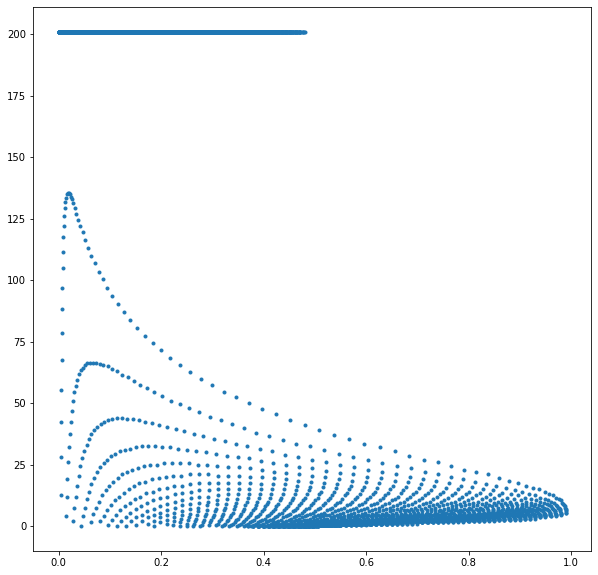

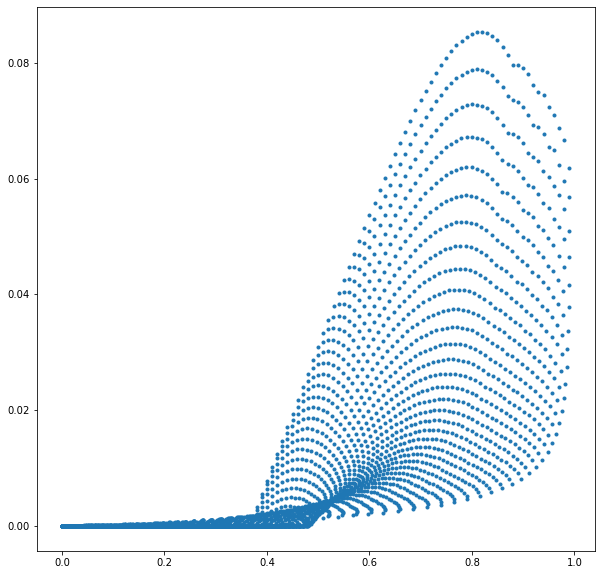

In [3]:
figsize(10,10)
matriz_ceros = zeros((101,100))
matriz_max = zeros_like(matriz_ceros)
matriz_min = zeros_like(matriz_ceros)
matriz_lea = zeros_like(matriz_ceros)

i = 0
lla = linspace(-3,0,101)
for la in lla:
    j = 0
    laa = linspace(0.01, 1.00, 100)
    for a in laa:
        ceros, d2max, d2min, dl = plot_rfn(rfl, [power(10.0, la), 0.0, 0.01, 0, 200.0, a, 0.1], "rfl (learning a)", sv = 3, grafica = 'd20',Nmax=200)
        matriz_ceros[i,j] = ceros
        matriz_max  [i,j] = d2max
        matriz_min  [i,j] = d2min
        matriz_lea  [i,j] = dl[1]
        print("\r%3d %3d %6.4f %6.4f %6.2f %6.4f %6.4f %6.4f"%(i, j, la, a, ceros, d2max, d2min, dl[1]), end = '');sys.stdout.flush()
        j += 1
    i += 1
print()
la_mapa = zeros((matriz_max.shape[0], matriz_max.shape[1], 4))
la_mapa[:,:,0],la_mapa[:,:,1],la_mapa[:,:,2], la_mapa[:,:,3] = matriz_ceros[...], matriz_max[...], matriz_min[...], matriz_lea[...]
scatter(matriz_lea, matriz_ceros, marker = '.')
show()
scatter(matriz_lea, matriz_max, marker = '.')
show()

100  99 lh 0.0000 hm 0.000000 cero  21.50 d2max 0.0000 d22 -0.0008 dl -0.100077

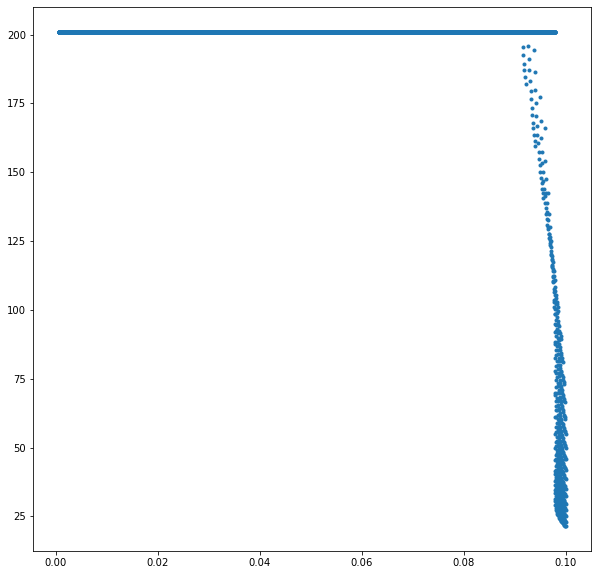

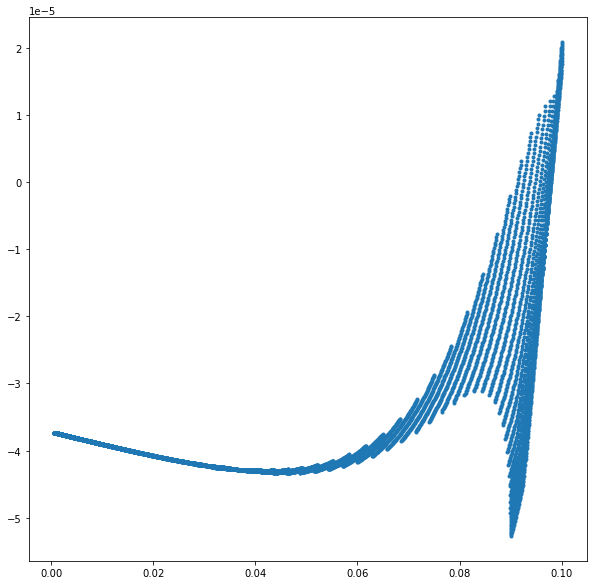

In [4]:
matriz_ceros = zeros((101,100))
matriz_max = zeros_like(matriz_ceros)
matriz_min = zeros_like(matriz_ceros)
matriz_lea = zeros_like(matriz_ceros)

i = 0
llh = linspace(-3, 0.0, 101)
lhm = linspace(0.01, 0, 100)
for lh in llh:
    j = 0
    for hm in lhm:
        ceros, d2max, d2min, dl = plot_rfn(rfl, [0.0, power(10, lh), hm, 0, 200.0, 0.1, 0.1], "rfl (learning h)", sv = 3, grafica = 'd20', Nmax = 200)
        print("\r%3d %3d lh %6.4f hm %8.6f cero %6.2f d2max %6.4f d22 %6.4f dl %6.4f"%(i, j, lh, hm, ceros, d2max, d2min, dl[2]), end = '');sys.stdout.flush()
        matriz_ceros[i,j] = ceros
        matriz_max  [i,j] = d2max
        matriz_min  [i,j] = d2min
        matriz_lea  [i,j] = abs(dl[2])
        j += 1
    i += 1
    
lh_mapa = zeros((matriz_max.shape[0], matriz_max.shape[1], 4))
lh_mapa[:,:,0],lh_mapa[:,:,1],lh_mapa[:,:,2],lh_mapa[:,:,3] = matriz_ceros, matriz_max, matriz_min, matriz_lea
scatter(matriz_lea, matriz_ceros, marker = '.')
show()
scatter(matriz_lea, matriz_max, marker = '.')
show()

In [ ]:
figsize(10,10)
matriz_ceros = zeros((101,100))
matriz_max = zeros_like(matriz_ceros)
matriz_min = zeros_like(matriz_ceros)
matriz_lea = zeros_like(matriz_ceros)

i = 0
for la in lla:
    j = 0
    laa = linspace(0.01, 1.00, 100)
    for a in laa:
        ceros, d2max, d2min, dl = plot_rfn(rfl, [power(10.0, la), 0.0, 0.01, 1, 200.0, a, 0.1], "rfl (learning a)", sv = 3, grafica = 'd20',Nmax=200)
        matriz_ceros[i,j] = ceros
        matriz_max  [i,j] = d2max
        matriz_min  [i,j] = d2min
        matriz_lea  [i,j] = abs(dl[1])
        print("\r%3d %3d %6.4f %6.4f %6.2f %6.4f %6.4f dl %6.4f"%(i, j, la, a, ceros, d2max, d2min, dl[1]), end = '');sys.stdout.flush()
        j += 1
    i += 1
print()
larmapa = zeros((matriz_max.shape[0], matriz_max.shape[1], 4))
larmapa[:,:,0],larmapa[:,:,1],larmapa[:,:,2],larmapa[:,:,3] = matriz_ceros, matriz_max, matriz_min, matriz_lea
scatter(matriz_lea, matriz_ceros, marker = '.')
show()
scatter(matriz_lea, matriz_max, marker = '.')
show()

 26  88 -2.2200 0.8900 201.00 -0.0000 -0.0207 dl 0.0061

In [ ]:
matriz_ceros = zeros((101,100))
matriz_max = zeros_like(matriz_ceros)
matriz_min = zeros_like(matriz_ceros)
matriz_lea = zeros_like(matriz_ceros)

i = 0

lhm = linspace(0.01, 0, 100)
for lh in llh:
    j = 0
    for hm in lhm:
        ceros, d2max, d2min, dl = plot_rfn(rfl, [0.0, power(10, lh), hm, 1, 200.0, 0.1, 0.1], "rfl (learning h)", sv = 3, grafica = 'd20', Nmax = 200)
        print("\r%3d %3d lh %6.4f hm %8.6f cero %6.2f d2max %6.4f d22 %6.4f dl %6.4f"%(i, j, lh, hm, ceros, d2max, d2min, dl[2]), end = '');sys.stdout.flush()
        matriz_ceros[i,j] = ceros
        matriz_max  [i,j] = d2max
        matriz_min  [i,j] = d2min
        matriz_lea  [i,j] = abs(dl[2])
        j += 1
    i += 1

lhrmapa = zeros((matriz_max.shape[0], matriz_max.shape[1], 4))
lhrmapa[:,:,0],lhrmapa[:,:,1],lhrmapa[:,:,2],lhrmapa[:,:,3] = matriz_ceros, matriz_max, matriz_min, matriz_lea
scatter(matriz_lea, matriz_ceros, marker = '.')
show()
scatter(matriz_lea, matriz_max, marker = '.')
show()

In [ ]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'

figsize(12,12)
fig, axs = plt.subplots(2, 2, sharex=True, sharey = True, gridspec_kw={'hspace': 0, 'wspace': 0})


#matriz_ceros = ma.masked_greater(matriz_ceros, 100)
axs[0,0].contourf(laa, lla, la_mapa[:,:,0], alpha = 0.25,   levels = [-1,1,11,200,201], cmap = cm.gray)
cc = axs[0,0].contour (laa, lla, la_mapa[:,:,0], colors='k', levels = [-1,1,11,200,201])
clabel(cc, inline = True)

axs[0,1].contourf(laa, lla, larmapa[:,:,0], alpha = 0.25,   levels = [-1,1,11,200,201], cmap = cm.gray)
cc = axs[0,1].contour (laa, lla, larmapa[:,:,0], colors='k', levels = [-1,1,11,200,201])
clabel(cc, inline = True)

lvl =[-0.001,-1e-4,0,1e-7,1e-4,0.001,0.01,0.04]
axs[1,0].contourf(laa, lla, la_mapa[:,:,1], alpha = 0.25, levels = lvl, cmap = cm.gray_r)
cc = axs[1,0].contour(laa, lla, la_mapa[:,:,1], colors = 'k', levels = lvl)
clabel(cc, inline = True)

axs[1,1].contourf(laa, lla, larmapa[:,:,1], alpha = 0.25, levels = lvl, cmap = cm.gray_r)
cc = axs[1,1].contour(laa, lla, larmapa[:,:,1], colors = 'k', levels = lvl)
clabel(cc, inline = True)

axs[0,0].text(0.9, -0.25, "A")
axs[0,1].text(0.9, -0.25, "B")
axs[1,0].text(0.9, -0.25, "C")
axs[1,1].text(0.9, -0.25, "D")

axs[0,0].text(0.42, -0.2, "Near Type II")
axs[0,0].text(0.1, -0.3, "Type III")
axs[0,0].text(0.5, -2.0, "Type II")

axs[0,1].text(0.5, -2.0, "Type II")
axs[0,1].text(0.2, -0.3, "Type III")
axs[0,1].text(0.5, -0.2, "Near Type II")

axs[1,0].text(0.42, -0.2, "Near Type II")
axs[1,0].text(0.1, -0.3, "Type III")
axs[1,0].text(0.5, -2.0, "Type II")

axs[1,1].text(0.5, -2.0, "Type II")
axs[1,1].text(0.2, -0.3, "Type III")
axs[1,1].text(0.5, -0.2, "Near Type II")

axs[0,0].set_ylabel("$Log_{10}(l_a)$")
axs[1,0].set_ylabel("$Log_{10}(l_a)$")
axs[1,0].set_xlabel("$a_0$")
axs[1,1].set_xlabel("$a_0$")

show()

In [ ]:
figsize(12,12)
fig, axs = plt.subplots(2, 2, sharex=True, sharey = True, gridspec_kw={'hspace': 0, 'wspace': 0})

axs[0,0].contourf(lhm, llh, lh_mapa[:,:,0], alpha = 0.25,   levels = [-1,1,100,200,201], cmap = cm.gray)
cc = axs[0,0].contour (lhm, llh, lh_mapa[:,:,0], colors='k', levels = [-1,1,100,200,201])
clabel(cc, inline = True)

axs[0,1].contourf(lhm, llh, lhrmapa[:,:,0], alpha = 0.25,   levels = [-1,1,100,200,201], cmap = cm.gray)
cc = axs[0,1].contour (lhm, llh, lhrmapa[:,:,0], colors='k', levels = [-1,1,100,200,201])
clabel(cc, inline = True)

lvl =[-2e-5,-1e-5,0,1e-5,3e-5]
axs[1,0].contourf(lhm, llh, lh_mapa[:,:,1], alpha = 0.25, levels = lvl, cmap = cm.gray_r)
cc = axs[1,0].contour(lhm, llh, lh_mapa[:,:,1], colors = 'k', levels = lvl)
clabel(cc, inline = True, fmt = "%7.5f")

axs[1,1].contourf(lhm, llh, lhrmapa[:,:,1], alpha = 0.25, levels = lvl, cmap = cm.gray_r)
cc = axs[1,1].contour(lhm, llh, lhrmapa[:,:,1], colors = 'k', levels = lvl)
clabel(cc, inline = True, fmt = "%7.5f")

axs[0,0].text(0.009, -0.25, "A")
axs[0,1].text(0.009, -0.25, "B")
axs[1,0].text(0.009, -0.25, "C")
axs[1,1].text(0.009, -0.25, "D")
axs[0,0].set_ylabel("$Log_{10}(l_h)$")
axs[1,0].set_ylabel("$Log_{10}(l_h)$")
axs[1,0].set_xlabel("$h_m$")
axs[1,1].set_xlabel("$h_m$")

axs[0,0].text(0.005,  -1.5, "Type II")
axs[0,0].text(0.0002, -0.2, "Near Type I")
axs[0,0].text(0.003,  -0.2, "Near Type II")

axs[0,1].text(0.005,  -1.5, "Type II")
axs[0,1].text(0.0002, -0.2, "Near Type I")
axs[0,1].text(0.003,  -0.2, "Near Type II")

axs[1,0].text(0.005,  -1.5, "Type II")
axs[1,0].text(0.0002, -0.2, "Near Type I")
axs[1,0].text(0.0055,  -0.2, "Near Type II")

axs[1,1].text(0.005,  -1.5, "Type II")
axs[1,1].text(0.0002, -0.2, "Near Type I")
axs[1,1].text(0.0055,  -0.2, "Near Type II")

show()

In [ ]:
figsize(16,16)
fig, axs = plt.subplots(2, 2, sharex='row', sharey = True, gridspec_kw={'hspace': 0, 'wspace': 0})

axs[0,0].scatter(lh_mapa[:,:,-1] * 10, lh_mapa[:,:,0], marker = '.')
axs[0,1].scatter(lhrmapa[:,:,-1] * 10, lhrmapa[:,:,0], marker = '.')
axs[1,0].scatter(la_mapa[:,:,-1], la_mapa[:,:,0], marker = '.')
axs[1,1].scatter(larmapa[:,:,-1], larmapa[:,:,0], marker = '.')
axs[0,0].set_ylabel("Inflection Point $(N)$")
axs[1,0].set_ylabel("Inflection Point $(N)$")
axs[1,0].set_xlabel("$\delta_l$")
axs[1,1].set_xlabel("$\delta_l$")


'''
axs[0,0].text(0.009, -0.25, "A")
axs[0,1].text(0.009, -0.25, "B")
axs[1,0].text(0.009, -0.25, "C")
axs[1,1].text(0.009, -0.25, "D")
axs[0,0].set_ylabel("$Log_{10}(l_h)$")
axs[1,0].set_ylabel("$Log_{10}(l_h)$")
axs[1,0].set_xlabel("$h_m$")
axs[1,1].set_xlabel("$h_m$")

axs[0,0].text(0.005,  -1.5, "Type II")
axs[0,0].text(0.0002, -0.2, "Near Type I")
axs[0,0].text(0.003,  -0.2, "Near Type II")

axs[0,1].text(0.005,  -1.5, "Type II")
axs[0,1].text(0.0002, -0.2, "Near Type I")
axs[0,1].text(0.003,  -0.2, "Near Type II")

axs[1,0].text(0.005,  -1.5, "Type II")
axs[1,0].text(0.0002, -0.2, "Near Type I")
axs[1,0].text(0.0055,  -0.2, "Near Type II")

axs[1,1].text(0.005,  -1.5, "Type II")
axs[1,1].text(0.0002, -0.2, "Near Type I")
axs[1,1].text(0.0055,  -0.2, "Near Type II")
'''
show()

In [ ]:
figsize(16,16)
fig, axs = plt.subplots(2, 2, sharex=True, sharey = 'row', gridspec_kw={'hspace': 0, 'wspace': 0})

axs[0,0].scatter(lh_mapa[:,:,-1] * 10, lh_mapa[:,:,1], marker = '.')
axs[0,1].scatter(lhrmapa[:,:,-1] * 10, lhrmapa[:,:,1], marker = '.')
axs[1,0].scatter(la_mapa[:,:,-1], la_mapa[:,:,1], marker = '.')
axs[1,1].scatter(larmapa[:,:,-1], larmapa[:,:,1], marker = '.')
axs[0,0].set_ylabel("Max second derivative")
axs[1,0].set_ylabel("Max second derivative")
axs[1,0].set_xlabel("$\delta_l$")
axs[1,1].set_xlabel("$\delta_l$")


'''
axs[0,0].text(0.009, -0.25, "A")
axs[0,1].text(0.009, -0.25, "B")
axs[1,0].text(0.009, -0.25, "C")
axs[1,1].text(0.009, -0.25, "D")
axs[0,0].set_ylabel("$Log_{10}(l_h)$")
axs[1,0].set_ylabel("$Log_{10}(l_h)$")
axs[1,0].set_xlabel("$h_m$")
axs[1,1].set_xlabel("$h_m$")

axs[0,0].text(0.005,  -1.5, "Type II")
axs[0,0].text(0.0002, -0.2, "Near Type I")
axs[0,0].text(0.003,  -0.2, "Near Type II")

axs[0,1].text(0.005,  -1.5, "Type II")
axs[0,1].text(0.0002, -0.2, "Near Type I")
axs[0,1].text(0.003,  -0.2, "Near Type II")

axs[1,0].text(0.005,  -1.5, "Type II")
axs[1,0].text(0.0002, -0.2, "Near Type I")
axs[1,0].text(0.0055,  -0.2, "Near Type II")

axs[1,1].text(0.005,  -1.5, "Type II")
axs[1,1].text(0.0002, -0.2, "Near Type I")
axs[1,1].text(0.0055,  -0.2, "Near Type II")
'''
show()